# Question 1

In [53]:
import pandas as pd
import numpy as np

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [55]:
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv("data.csv")

In [57]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [58]:
df['card'] = df['card'].map({'yes': 1, 'no': 0})

In [59]:
#split the data
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state = 1)

#delet index
df_train = df_train.reset_index(drop= True)
df_val = df_val.reset_index(drop= True)
df_test = df_test.reset_index(drop= True)

#y target
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

#del median_house_value
del df_train['card']
del df_val['card']
del df_test['card']

In [60]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

**Confusion table**

In [61]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum() #true positive
tn = (predict_negative & actual_negative).sum() #true negative

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [62]:
cofustion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
cofustion_matrix

array([[ 52,   1],
       [  7, 204]])

In [63]:
#percent
(cofustion_matrix/ cofustion_matrix.sum()).round(2)

array([[0.2 , 0.  ],
       [0.03, 0.77]])

**ROC AUC**

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [65]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


*Answer - share*

# Question 2

In [66]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [67]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [68]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.9696969696969697

In [69]:
roc_auc_score(y_val, y_pred)
auc.round(3)

0.604

*Answer 0.615*

# Question 3

In [70]:
scores = []
#ROC оценивает все пороги 
thresholds = np.linspace(0, 1, 101)

#сначала таблица истинности
for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)

  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum() #true positive
  tn = (predict_negative & actual_negative).sum() #true negative

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  scores.append((t, tp, fp, fn, tn))

In [71]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns= columns)

In [72]:
df_scores[::10] #c 1 по последний с шагом 10

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [73]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

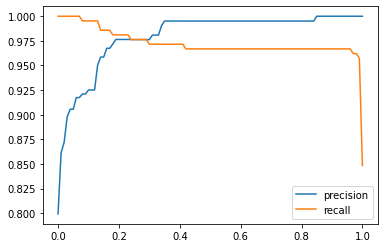

In [75]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

*Answer 0.3*

# Question 4
f1 = 2 * p * r/(r+p)

In [84]:
df_scores['f1'] = 2 * df_scores['p']*df_scores['r']/(df_scores['p']+df_scores['r'])

In [86]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,p,r,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


*Answer 0.4*

# Qestion 5

In [87]:
from sklearn.model_selection import KFold

In [88]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [91]:
def train(df_train, y_train, C=1.0):
  dicts = df_train[categorical + numerical].to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  #добавили параметр С
  model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model

In [92]:
dv, model = train(df_train, y_train, C=0.001)

In [93]:
#это функция для составления прогнозов
#попробуем для данных проверки, словаря, векторизатора и модели
def predict(df, dv, model):
  dicts = df[categorical + numerical].to_dict(orient='records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [94]:
y_pred = predict(df_val, dv, model)

In [89]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [90]:
from tqdm.auto import tqdm

In [109]:
for train_idx, val_idx in kfold.split(df_full_train):
  #обучающий dataframe для каждой итерации
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.card.values
  y_val = df_val.card.values

  dv, model = train(df_train, y_train, C=1.0)
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
  #nt('%s %.3f +- %.3f' % (1.0, np.mean(scores), np.std(scores)))

0.996 +- 0.003
